# Computational Physics: Final Assignment

### FOLDING OF A LATTICE PROTEIN USING THE METROPOLIS MONTE CARLO ALGORITHM

Andrea Costa, S4636708

### Import Packages

In [2]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Setting up the MMC program

### Part 1: Preparing, visualizing and analyzing the chain

#### Q1:

Pseudocode;

Input: N (chain length), p_H (hydrophobic fraction), seed (optional)

```text
Set RNG seed if provided
Repeat:
  coords <- [(0,0)]
  occupied <- set((0,0))
  While length(coords) < N:
    curr <- last(coords)
    dirs <- shuffled list of 4 unit steps: [(1,0),(-1,0),(0,1),(0,-1)]
    placed <- false
    For d in dirs:
      cand <- curr + d
      If cand not in occupied:
        append cand to coords
        add cand to occupied
        placed <- true
        break
    If not placed:
      restart from scratch (new coords/occupied)   # trapped configuration
Until length(coords) == N

For each of N positions:
  assign bead 'H' with probability p_H else 'P'

Return coords, bead_sequence

In [3]:
def random_walk_hp(N, p_H=0.5, seed=None):
    """
    Generate a 2D self-avoiding random walk of N lattice points with HP bead types;
    Returns (coords, seq) where coords is a list of (x,y) ints and seq is a list of 'H'/'P' strings
    """
    if not (0 <= p_H <= 1):
        raise ValueError("p_H must be between 0 and 1.")
    if N < 1:
        raise ValueError("N must be >= 1.")
    if seed is not None:
        random.seed(seed)

    steps = [(1,0), (-1,0), (0,1), (0,-1)] #4 possible steps: right, left, up, down

    while True:
        coords = [(0, 0)]
        occupied = {(0, 0)}
        ok = True

        while len(coords)<N:
            x, y = coords[-1]
            dirs = steps[:] # try all four directions in random order
            random.shuffle(dirs)

            placed = False
            for dx, dy in dirs:
                cand = (x + dx, y + dy)
                if cand not in occupied:
                    coords.append(cand)
                    occupied.add(cand)
                    placed = True
                    break # placed this bead, move on to next

            if not placed:
                ok = False # dead end, restart
                break

        if ok: # successfully placed N beads
            break

    seq = ['H' if random.random() < p_H else 'P' for _ in range(N)]
    return coords, seq


In [4]:
# Q2

coords, seq = random_walk_hp(25, p_H=0.5, seed=1)
print("Coordinates:", coords)
print("Sequence:", seq)

# confirm the ratio of H:P monomers is p_H
trials = 5000
total_H = 0
for _ in range(trials):
    _, seq = random_walk_hp(25, p_H=0.5)  # independent draws
    total_H += seq.count('H')

mean_frac_H = total_H / (trials * 25)
print(f"Mean fraction of H: {mean_frac_H}, Expected: 0.5")

Coordinates: [(0, 0), (0, -1), (0, -2), (1, -2), (1, -1), (1, 0), (1, 1), (0, 1), (0, 2), (-1, 2), (-2, 2), (-3, 2), (-3, 3), (-3, 4), (-2, 4), (-2, 5), (-1, 5), (-1, 4), (0, 4), (1, 4), (2, 4), (2, 5), (1, 5), (0, 5), (0, 6)]
Sequence: ['P', 'P', 'H', 'H', 'H', 'H', 'P', 'P', 'P', 'H', 'H', 'P', 'P', 'P', 'P', 'P', 'H', 'P', 'P', 'P', 'H', 'H', 'P', 'P', 'H']
Mean fraction of H: 0.498976, Expected: 0.5


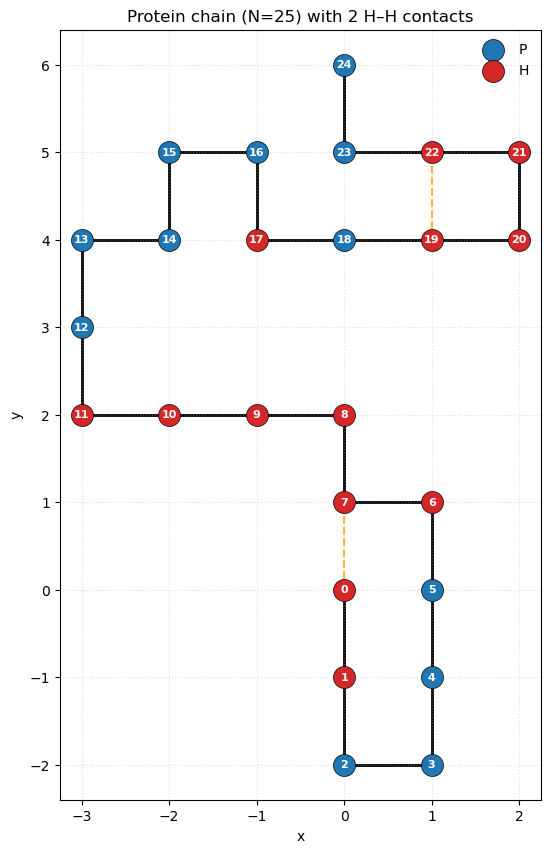

In [5]:
# Q3

def visualize_chain(coords, seq, show_index=False, savepath=None, show=True):
    """
    Plot 2D lattice chain with bonds, monomer types (H/P), and non-bonded H–H contacts
    """
    N = len(coords)
    steps = [(1,0), (-1,0), (0,1), (0,-1)]
    pos_to_idx = {coords[i]: i for i in range(N)} # map (x,y) to index i 

    # find H–H contacts (adjacent on lattice but not bonded in chain)
    contacts = set()
    for i, (x, y) in enumerate(coords):
        if seq[i] != 'H':
            continue
        for dx, dy in steps:
            j = pos_to_idx.get((x+dx, y+dy)) # neighbor index or None
            if j is None or abs(j - i) == 1: # bonded neighbors
                continue
            if seq[j] == 'H':
                a, b = (i, j) if i < j else (j, i) # order pair
                contacts.add((a, b))

    fig, ax = plt.subplots(figsize=(10, 10))

    # bonds
    for i in range(N-1):
        x0, y0 = coords[i]
        x1, y1 = coords[i+1]
        ax.plot([x0, x1], [y0, y1], '-', color='black', linewidth=2, zorder=1)

    # H–H contacts
    for i, j in contacts:
        x0, y0 = coords[i]
        x1, y1 = coords[j]
        ax.plot([x0, x1], [y0, y1], '--', color='orange', linewidth=1.5, alpha=0.8, zorder=0)

    # monomers
    xs_H = [x for (x, _), t in zip(coords, seq) if t == 'H']
    ys_H = [y for (_, y), t in zip(coords, seq) if t == 'H']
    xs_P = [x for (x, _), t in zip(coords, seq) if t == 'P']
    ys_P = [y for (_, y), t in zip(coords, seq) if t == 'P']
    ax.scatter(xs_P, ys_P, s=250, c='tab:blue', edgecolors='k', linewidths=0.5, label='P', zorder=3)
    ax.scatter(xs_H, ys_H, s=250, c='tab:red',  edgecolors='k', linewidths=0.5, label='H', zorder=4)

    if show_index:
        for i, (x, y) in enumerate(coords):
            ax.text(x, y, str(i), fontsize=8, color='white', zorder=5, ha='center', va='center', weight='bold')

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Protein chain (N={N}) with {len(contacts)} H–H contacts')
    ax.legend(frameon=False)
    ax.grid(True, linestyle=':', alpha=0.4)
    
    if savepath is not None:
        folder = os.path.dirname(savepath)
        if folder:
            os.makedirs(folder, exist_ok=True)
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)
    
visualize_chain(coords, seq, show_index=True)

#### Q4:

Pseudocode;

```text
Input: coords (list of (x,y)), seq (list of 'H'/'P')
pos_to_idx <- map from coordinate to index
contacts <- empty set
For each index i with seq[i] = 'H':
  For each of 4 lattice neighbors of coords[i]:
    If neighbor exists at index j and seq[j] = 'H' and |i-j| != 1:
      Add unordered pair (min(i,j), max(i,j)) to contacts
E <- −|contacts| # reduced units: ε = 1
Return E, contacts

In [6]:
def energy_hp(coords, seq):
    """
    Energy in reduced units (epsilon=1) and the set of H–H contact pairs;
    Returns (E, contacts), where contacts are index pairs (i,j), i<j
    """
    steps = [(1,0), (-1,0), (0,1), (0,-1)]
    pos_to_idx = {coords[i]: i for i in range(len(coords))} # map (x,y) to index i
    contacts = set()

    for i, (x, y) in enumerate(coords):
        if seq[i] != 'H':
            continue
        for dx, dy in steps:
            j = pos_to_idx.get((x+dx, y+dy))
            if j is None:
                continue
            if seq[j] == 'H' and abs(j - i) != 1:   # exclude covalent neighbors
                a, b = (i, j) if i < j else (j, i)
                contacts.add((a, b))

    E = -len(contacts)   # epsilon = 1
    return E, contacts


Energy: -2; #H–H contacts: 2; contacts: [(0, 7), (19, 22)]


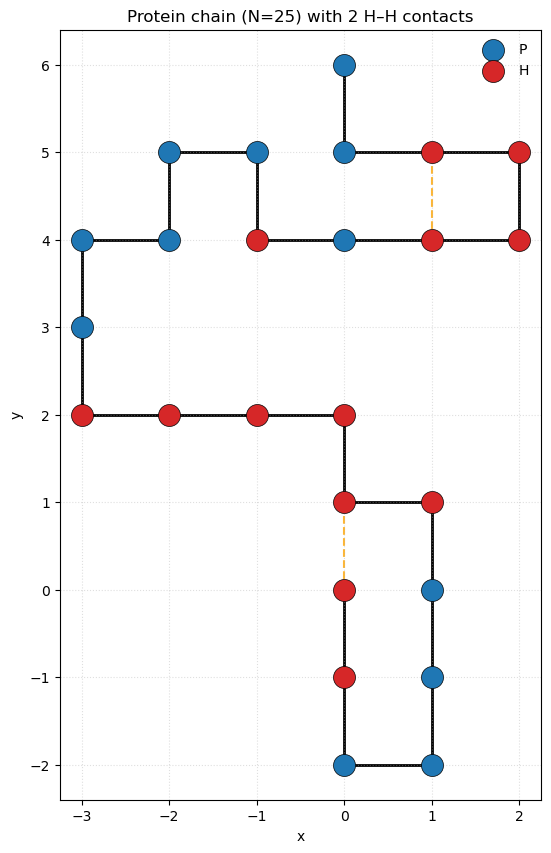

In [7]:
E, contacts = energy_hp(coords, seq)
print(f"Energy: {E}; #H–H contacts: {len(contacts)}; contacts: {sorted(contacts)}")

# Now plot and check that the number of dashed contact lines equals len(contacts)
visualize_chain(coords, seq)

### Part 2: Implementing the Monte Carlo moves

#### Q1:

Pseudocode;

```text
Input: coords (list of integer lattice points)

Pick random index i
If i is an end (0 or N−1): # end rotation
  anchor <- coords[1] if i=0 else coords[N−2]
  candidates <- 4 neighbors of anchor excluding current end position
  Remove any candidate that is already occupied by the chain
  If candidates not empty:
    Move monomer i to a random candidate
  Else:
    Keep old configuration

Else: # internal kink jump
  prev ← coords[i−1]
  next <- coords[i+1]
  cur <- coords[i]
  If (prev, cur, next) form a right angle (not collinear):
    target <- prev + next − cur # opposite plaquette corner
    If target not occupied:
      Move monomer i to target
    Else keep old configuration
  Else keep old configuration

Return new coords (or old if no move possible)

In [8]:
def kink_or_end_move(coords):
    """
    Try a kink jump (internal) or end rotation (if an end is picked);
    Returns (new_coords, move_type, idx), where move_type in {'kink','end','none'}.
    """
    N = len(coords)
    steps = [(1,0), (-1,0), (0,1), (0,-1)]
    occupied = set(coords)

    i = random.randrange(N)
    cur = coords[i] # current position

    # end rotation
    if i == 0 or i == N-1:
        anchor = coords[1] if i == 0 else coords[N-2] # fixed neighbor
        candidates = []
        for dx, dy in steps:
            cand = (anchor[0]+dx, anchor[1]+dy)
            if cand == cur:
                continue
            if cand in occupied:
                continue
            candidates.append(cand)
        if candidates:
            new_coords = coords.copy()
            new_coords[i] = random.choice(candidates)
            return new_coords, 'end', i
        return coords, 'none', i

    # internal kink jump
    prev = coords[i-1]
    nxt = coords[i+1]

    # check kink: neighbors must be perpendicular around cur (dot product = 0)
    v1 = (prev[0] - cur[0], prev[1] - cur[1])
    v2 = (nxt[0] - cur[0], nxt[1] - cur[1])
    if v1[0]*v2[0] + v1[1]*v2[1] == 0:
        target = (prev[0] + nxt[0] - cur[0], prev[1] + nxt[1] - cur[1])  # opposite corner
        if target not in occupied:
            new_coords = coords.copy()
            new_coords[i] = target
            return new_coords, 'kink', i

    return coords, 'none', i

none 5


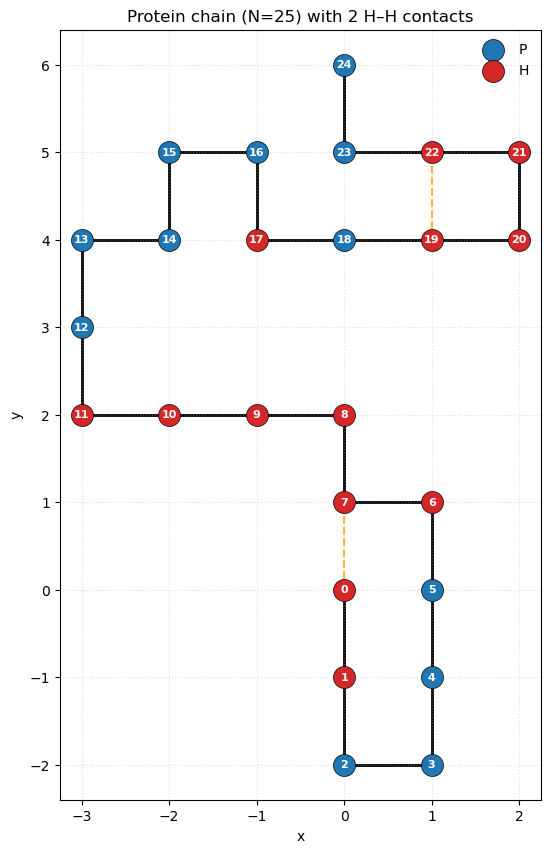

In [9]:
new_coords, mtype, idx = kink_or_end_move(coords)
print(mtype, idx)
visualize_chain(new_coords, seq, show_index=True)

#### Q2:

pseudocode;

```text
Input: coords
Pick random pivot index k
Choose side to rotate:
  if k=0 -> rotate right side; if k=N−1 -> rotate left side; else choose left or right at random
Choose direction (cw or ccw)
Let P = coords[k]
Compute new positions for all indices on chosen side:
  translate by −P, apply 90° rotation:
    cw: (x,y)->( y,−x) ;  ccw: (x,y)->(−y, x)
  translate back by +P
If any new position overlaps with the fixed part (including P) or with another rotated bead:
  keep old configuration
Else:
  write rotated positions into coords and return

In [10]:
def pivot_move(coords):
    """
    One +/-90° pivot move around a random monomer;
    Returns (new_coords, move, k, side, direction)
    """
    N = len(coords)
    k = random.randrange(N) # pivot index

    # choose which side rotates
    if k == 0: # end rotation
        side = 'right'
        rot_idx = range(1, N)
    elif k == N-1: # end rotation
        side = 'left'
        rot_idx = range(0, N-1)
    else: # internal pivot
        if random.random() < 0.5:
            side = 'left'
            rot_idx = range(0, k)
        else:
            side = 'right'
            rot_idx = range(k+1, N)

    direction = random.choice(['cw', 'ccw'])
    px, py = coords[k]

    def rot90(x, y):
        # Rotate (x, y) by 90 degrees
        return (y, -x) if direction == 'cw' else (-y, x)

    fixed = {coords[i] for i in range(N) if i not in rot_idx}  # includes pivot
    new_positions = []
    for i in rot_idx:
        x, y = coords[i]
        rx, ry = rot90(x - px, y - py)
        nx, ny = px + rx, py + ry
        new_positions.append((nx, ny))

    # overlap checks
    if len(set(new_positions)) != len(new_positions):
        return coords, 'none', k, side, direction
    if any(p in fixed for p in new_positions):
        return coords, 'none', k, side, direction

    new_coords = coords.copy()
    for i, p in zip(rot_idx, new_positions):
        new_coords[i] = p
    return new_coords, 'pivot', k, side, direction


none 15 left ccw


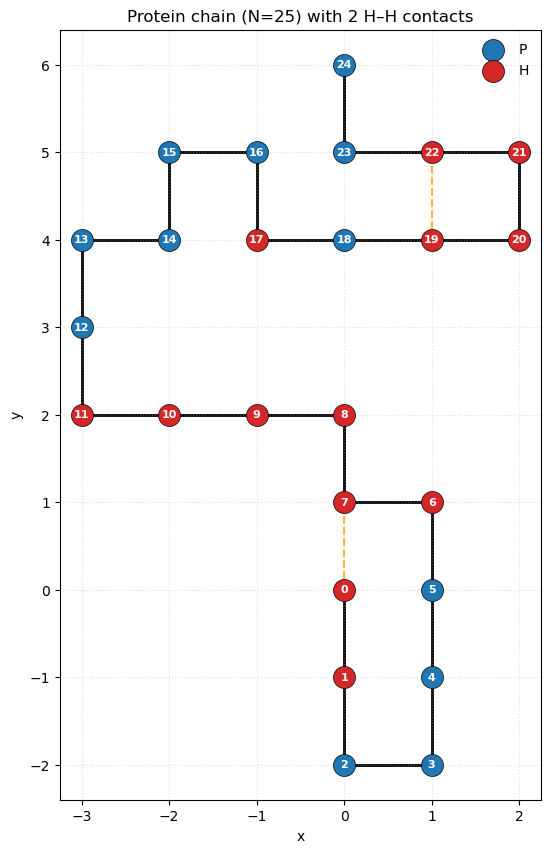

In [11]:
new_coords, move, k, side, direction = pivot_move(coords)
print(move, k, side, direction)
visualize_chain(new_coords, seq, show_index=True)

### Part 3: The full MMC program

Pseudocode;

```text
Input: T, N, p_H, max_steps, sample_every
Initialize coords, seq with random_walk_hp(N, p_H)
Compute E = energy_hp(coords)
For step = 1 to max_steps:
  Repeat (cap at K tries) until a new configuration is found:
    With prob 1/2 try kink/end move else pivot move -> trial_coords
  If no new config found: continue
  E_trial = energy_hp(trial_coords)
  DeltaE = E_trial − E
  If DeltaE <= 0 accept
  Else accept with prob exp(−DeltaE/T)
  If accepted: coords ← trial_coords; E <- E_trial
  If step % sample_every == 0: store E (and optionally coords)
Return final coords, seq, energy trace, acceptance rate

In [12]:
def mmc_run(T=1.0, N=25, p_H=0.5, max_steps=10000, sample_every=100, seed=None):
    """
    Metropolis Monte Carlo for the 2D HP model in reduced units (k_B=epsilon=1);
    Returns dict with final state and traces
    """
    if T < 0:
        raise ValueError("Temperature T must be >= 0.")
    if seed is not None:
        random.seed(seed)

    coords, seq = random_walk_hp(N, p_H)
    E, _ = energy_hp(coords, seq)

    energies = [E]
    accepted = 0
    attempts_per_step_cap = 100 # needed to avoid infinite loops

    for step in range(1, max_steps+1):
        # propose a new configuration
        trial = coords
        for _ in range(attempts_per_step_cap): #
            if random.random() < 0.5:
                cand, mtype, _ = kink_or_end_move(coords)
            else:
                cand, mtype, _, _, _ = pivot_move(coords)
            if cand != coords: # new geometry found
                trial = cand
                break
        if trial == coords: # no valid move found this step
            if step % sample_every == 0:
                energies.append(E)
            continue

        # metropolis test
        E_trial, _ = energy_hp(trial, seq)
        dE = E_trial - E
        accept = False
        if dE <= 0:
            accept = True
        elif T > 0 and random.random() < np.exp(-dE/T):
            accept = True

        if accept:
            coords = trial
            E = E_trial
            accepted += 1

        if step % sample_every == 0:
            energies.append(E)

    return {"coords": coords, "seq": seq, "energies": energies, "final_energy": E, "accept_rate": accepted/max_steps}


final E: -1 | accept rate: 0.824


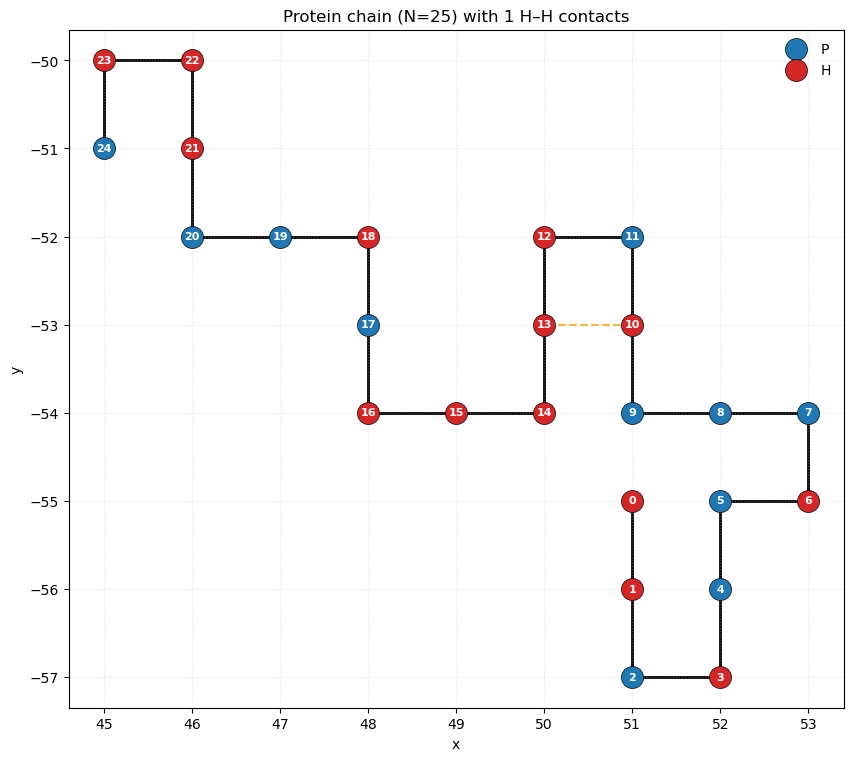

In [13]:
res = mmc_run(T=1.0, N=25, p_H=0.5, max_steps=10000, sample_every=100, seed=111)
print("final E:", res["final_energy"], "| accept rate:", f"{res['accept_rate']:.3f}")
visualize_chain(res["coords"], res["seq"], show_index=True)

## Protein Folding Simulations

### Benchmarking

HP sequence: H-H-P-H-P-P-H-P-P-P-H-P-H-H-H-H-H-P-H-P-P-H-H-H-P
Initial energy: -3


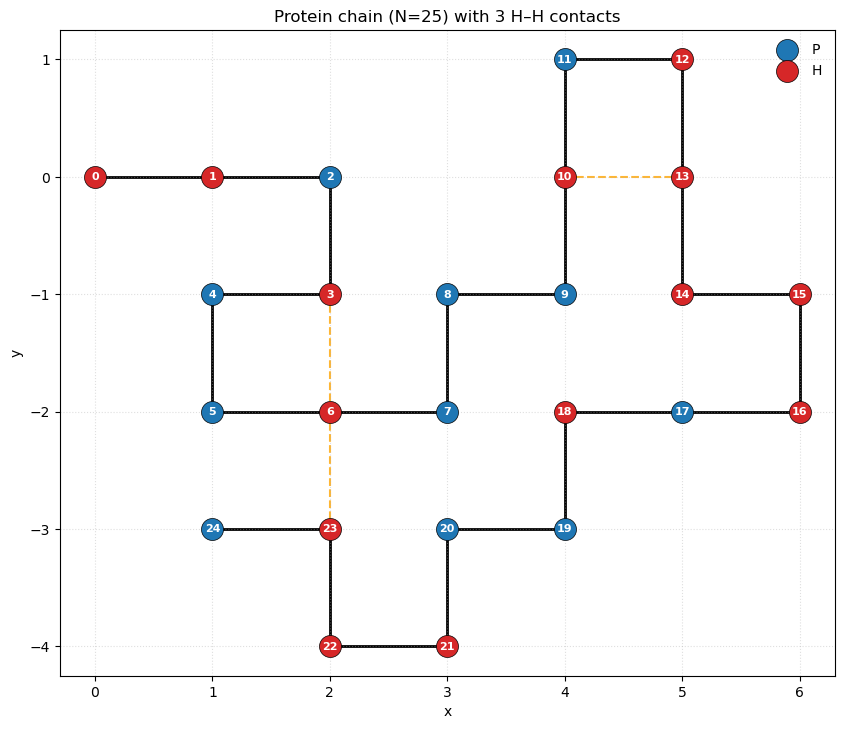

In [14]:
N_bm = 25
pH_bm = 0.50
T_bm = 1.0 # reduced temperature (epsilon = k_B = 1)
samp = 100 # store energy every 100 steps
steps = 100000

coords_init, seq_init = random_walk_hp(N_bm, p_H=pH_bm, seed=111)
seq_str = "-".join(seq_init)
E0, _ = energy_hp(coords_init, seq_init)

print("HP sequence:", seq_str)
print("Initial energy:", E0)
visualize_chain(coords_init, seq_init, show_index=True)

In [15]:
def moving_average(xs, w=10):
    """Simple moving average of a list xs with window w (w>=1)"""
    if w <= 1 or w >= len(xs): 
        return xs[:]
    out = []
    s = sum(xs[:w])
    out.append(s/w)
    for i in range(w, len(xs)):
        s += xs[i]-xs[i-w]
        out.append(s/w)
    return [out[0]]*(w-1) + out

def detect_plateau(energies, patience=8):
    """
    Return index (in the energies array) where the running minimum stops improving
    for 'patience' consecutive samples. If never, return None
    """
    run_min = np.inf
    stall = 0
    for i, e in enumerate(energies):
        if e<run_min-1e-9:
            run_min = e
            stall = 0
        else:
            stall += 1
        if stall >= patience:
            return i
    return None

# Run the MMC
res = mmc_run(T=T_bm, N=N_bm, p_H=pH_bm, max_steps=steps, sample_every=samp)

E_trace = res["energies"] 
E_smooth = moving_average(E_trace, w=10)
i_plateau = detect_plateau(E_smooth, patience=8)

print(f"Final energy: {res['final_energy']}, accept rate: {res['accept_rate']:.3f}")
if i_plateau is not None:
    iters_needed = i_plateau*samp
    print(f"Estimated convergence to fluctuating minimum at ~{iters_needed} iterations (sample {i_plateau} of {len(E_trace)-1})")
else:
    print("No clear plateau detected. Increase steps or try a different T")


Final energy: -2, accept rate: 0.917
Estimated convergence to fluctuating minimum at ~800 iterations (sample 8 of 1000)


In [16]:
def mmc_run_fixed_seq(T, steps, sample_every, coords0, seq, seed=None):
    """MMC with fixed seq and given start coords."""
    if seed is not None: random.seed(seed)
    coords = coords0.copy()
    E, _ = energy_hp(coords, seq)
    energies = [E]
    accepted = 0
    cap = 100
    for s in range(1, steps+1):
        trial = coords
        for _ in range(cap):
            if random.random() < 0.5:
                cand, *_ = kink_or_end_move(coords)
            else:
                cand, *_ = pivot_move(coords)
            if cand != coords:
                trial = cand
                break
        if trial != coords:
            E_trial, _ = energy_hp(trial, seq)
            dE = E_trial - E
            if dE <= 0 or (T > 0 and random.random() < np.exp(-dE/T)):
                coords = trial
                E = E_trial
                accepted += 1
        if s % sample_every == 0:
            energies.append(E)
    return {"coords": coords, "energies": energies, "final_energy": E, "accept_rate": accepted/steps}

def canonical_path(coords):
    """Rigid-motion canonical form (8 symmetries); Keeps bead order"""
    def rots(p):  # (x,y) -> 4 rotations
        x,y=p; return [(x,y),(y,-x),(-x,-y),(-y,x)]
    def refl(p):  # reflect across y-axis
        x,y=p; return (-x,y)
    best = None
    for r in range(4):
        for mirror in (False, True):
            L = []
            for x,y in coords:
                x,y = rots((x,y))[r]
                if mirror: x,y = refl((x,y))
                L.append((x,y))
            x0,y0 = L[0]
            L = [(x-x0,y-y0) for x,y in L]
            t = tuple(L)
            if best is None or t < best: best = t
    return best


repeats = 20
Final energy stats: min: -7; mean: -3.15, std: 1.7965244223221684
Accept rate (mean ± sd): 0.832 ± 0.003
convergence iters (median, IQR): 800, (800, 800)

Unique folded shapes among final conformations: 20
  #1: count=1
  #2: count=1
  #3: count=1
  #4: count=1
  #5: count=1
  #6: count=1
  #7: count=1
  #8: count=1
  #9: count=1
  #10: count=1
  #11: count=1
  #12: count=1
  #13: count=1
  #14: count=1
  #15: count=1
  #16: count=1
  #17: count=1
  #18: count=1
  #19: count=1
  #20: count=1


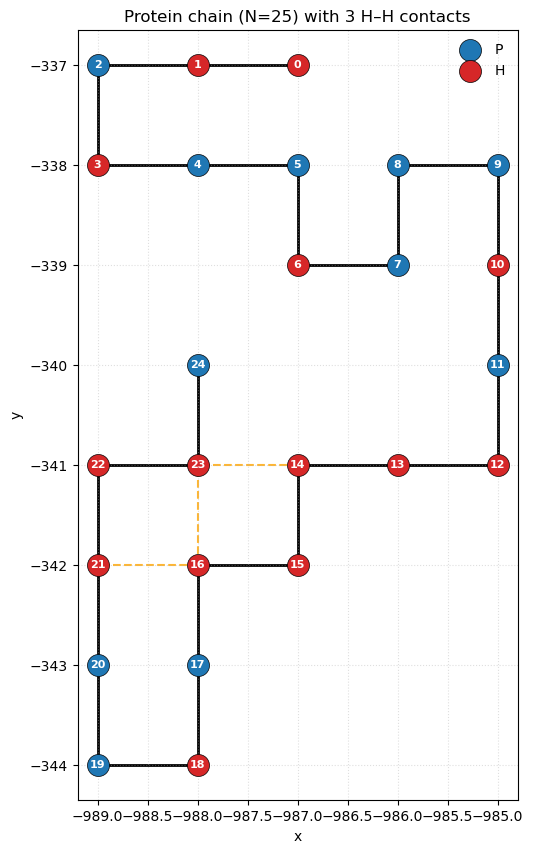

In [17]:
R = 20 # repeats
shape_counts = {}
shape_example = {}
summ = []

for rep in range(R):
    res_rep = mmc_run_fixed_seq(T_bm, steps, samp, coords_init, seq_init, seed=1+rep)
    sig = canonical_path(res_rep["coords"])
    shape_counts[sig] = shape_counts.get(sig, 0) + 1
    if sig not in shape_example:
        shape_example[sig] = res_rep["coords"]
    # plateau estimate per run
    ip = detect_plateau(moving_average(res_rep["energies"], w=10), patience=8)
    iters_needed = None if ip is None else ip*samp
    summ.append((res_rep["final_energy"], res_rep["accept_rate"], iters_needed))

print(f"repeats = {R}")
print(f"Final energy stats: min: {np.min([e for e,_,_ in summ])}; mean: {np.mean([e for e,_,_ in summ])}, std: {np.std([e for e,_,_ in summ])}")
print(f"Accept rate (mean ± sd): {np.mean([a for _,a,_ in summ]):.3f} ± {np.std([a for _,a,_ in summ]):.3f}")
conv = [c for *_,c in summ if c is not None]
if conv:
    print(f"convergence iters (median, IQR): {int(np.median(conv))}, ({int(np.percentile(conv,25))}, {int(np.percentile(conv,75))})")

print(f"\nUnique folded shapes among final conformations: {len(shape_counts)}")
for k,(sig,count) in enumerate(sorted(shape_counts.items(), key=lambda kv:-kv[1]), start=1):
    print(f"  #{k}: count={count}")

# visualize the most frequent final shape
top_sig = max(shape_counts.items(), key=lambda kv: kv[1])[0]
coords_top = shape_example[top_sig]
visualize_chain(coords_top, seq_init, show_index=True)

In [18]:
temps = [0.3, 0.6, 1.0, 1.5]
R = 20 # repeats per temperature

bestEs, nearCounts, uniqNear, modalFrac = [], [], [], []

for T in temps:
    shapes, Efin = [], []
    for r in range(R):
        res = mmc_run_fixed_seq(T, steps, samp, coords_init, seq_init, seed=100000+r+int(100*T))
        shapes.append(canonical_path(res["coords"]))
        Efin.append(res["final_energy"])

    Efin = np.array(Efin, int)
    bestE = int(Efin.min())
    mask = (Efin == bestE)
    near = [s for s, m in zip(shapes, mask) if m]
    c_all = Counter(shapes)
    c = Counter(near)

    bestEs.append(bestE)
    nearCounts.append(len(near))
    uniqNear.append(len(c) if near else 0)
    modalFrac.append((max(c.values())/len(near)) if near else 0.0)

# print a compact table
print("T   | uniqueAll | bestE | nearMin_count | unique_near | modal_frac_near")
for T, uA, bE, nC, uN, mF in zip(temps, c_all, bestEs, nearCounts, uniqNear, modalFrac):
    print(f"{T:3.1f} | {len(uA):9d} | {bE:5d} | {nC:13d} | {uN:12d} | {mF:15.2f}")

T   | uniqueAll | bestE | nearMin_count | unique_near | modal_frac_near
0.3 |        25 |   -11 |             5 |            5 |            0.20
0.6 |        25 |   -10 |             1 |            1 |            1.00
1.0 |        25 |    -7 |             1 |            1 |            1.00
1.5 |        25 |    -4 |             1 |            1 |            1.00


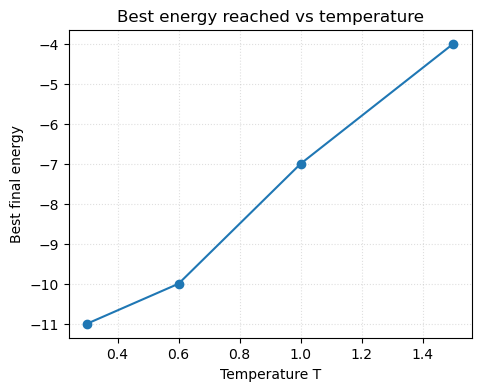

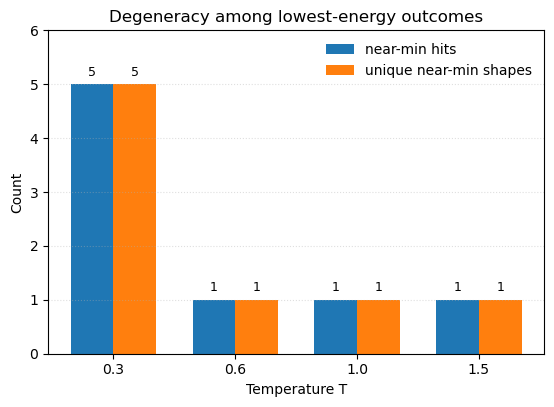

In [19]:
# figure 1: best energy vs T
plt.figure(figsize=(5.2,4))
plt.plot(temps, bestEs, marker='o')
plt.xlabel("Temperature T")
plt.ylabel("Best final energy")
plt.title("Best energy reached vs temperature")
plt.grid(True, linestyle=":", alpha=0.4)
plt.show()

# figure 2: degeneracy among near-min states
x = np.arange(len(temps))
w = 0.35
plt.figure(figsize=(6.4,4.2))
plt.bar(x - w/2, nearCounts, width=w, label="near-min hits")
plt.bar(x + w/2, uniqNear,   width=w, label="unique near-min shapes")
plt.xticks(x, [f"{T:.1f}" for T in temps])
plt.xlabel("Temperature T")
plt.ylabel("Count")
plt.title("Degeneracy among lowest-energy outcomes")
plt.legend(frameon=False)
for xi, a, b in zip(x, nearCounts, uniqNear):
    plt.text(xi - w/2, a + 0.1, str(a), ha='center', va='bottom', fontsize=9)
    plt.text(xi + w/2, b + 0.1, str(b), ha='center', va='bottom', fontsize=9)
plt.ylim(0, max(nearCounts + uniqNear) + 1)
plt.grid(True, axis='y', linestyle=":", alpha=0.4)
plt.show()

In [20]:

steps_per_run = steps
sample_every = samp

p_list = [0.40, 0.50, 0.60]
S = 3
tol = 0

def summarize_one_sequence(seq, coords0):
    finalEs, accs, shapes = [], [], []
    for r in range(R):
        res = mmc_run_fixed_seq(T_bm, steps_per_run, sample_every, coords0, seq, seed=100000+r)
        finalEs.append(res["final_energy"])
        accs.append(res["accept_rate"])
        shapes.append(canonical_path(res["coords"]))
    finalEs = np.array(finalEs, int)

    bestE = int(finalEs.min())
    near = [s for s, E in zip(shapes, finalEs) if E <= bestE + tol]
    c_near = Counter(near) if near else Counter()

    seq_stats = {
        "bestE": bestE,
        "mean_finalE": float(finalEs.mean()),
        "std_finalE": float(finalEs.std(ddof=1)) if len(finalEs) > 1 else 0.0,
        "acc_mean": float(np.mean(accs)),
        "near_count": len(near),
        "unique_near": len(c_near),
        "modal_frac_near": (max(c_near.values())/len(near)) if near else 0.0,
    }
    return seq_stats

print(f"Hydrophobicity sweep at fixed T={T_bm} (N={N_bm}, steps={steps_per_run}, sample_every={sample_every})")
print("p_H | bestE_mean±sd | finalE_mean±sd | accept_rate mean | near_min hits (avg) | unique_near (avg) | modal_frac_near (avg) | example sequence")

for p in p_list:
    # run S different sequences at this p_H
    seq_stats_list = []
    ex_seq = None
    for s in range(S):
        # make one sequence and a matching initial conformation
        coords0, seq = random_walk_hp(N_bm, p_H=p, seed=100000+s+int(100*p))
        if ex_seq is None:
            ex_seq = "".join(seq)
        seq_stats_list.append(summarize_one_sequence(seq, coords0))

    # aggregate over the S sequences
    bestEs = np.array([d["bestE"] for d in seq_stats_list], float)
    meanEs = np.array([d["mean_finalE"] for d in seq_stats_list], float)
    stdEs  = np.array([d["std_finalE"] for d in seq_stats_list], float)
    accs   = np.array([d["acc_mean"] for d in seq_stats_list], float)
    nearC  = np.array([d["near_count"] for d in seq_stats_list], float)
    uniqN  = np.array([d["unique_near"] for d in seq_stats_list], float)
    modalF = np.array([d["modal_frac_near"] for d in seq_stats_list], float)

    # print compact, report-ready line
    def pm(x): return f"{np.mean(x):.2f} ± {np.std(x, ddof=1):.2f}" if len(x)>1 else f"{float(x):.2f}"
    print(f"{p:3.2f} | {pm(bestEs)} | {pm(meanEs)} | {np.mean(accs):.3f} "
          f"| {np.mean(nearC):.2f} | {np.mean(uniqN):.2f} | {np.mean(modalF):.2f} | {ex_seq}")


Hydrophobicity sweep at fixed T=1.0 (N=25, steps=100000, sample_every=100)
p_H | bestE_mean±sd | finalE_mean±sd | accept_rate mean | near_min hits (avg) | unique_near (avg) | modal_frac_near (avg) | example sequence
0.40 | -3.00 ± 1.73 | -1.10 ± 0.93 | 0.936 | 2.67 | 2.67 | 0.72 | HPPPHHPPPPPPHPPHHPPPPPPHP
0.50 | -4.33 ± 0.58 | -1.60 ± 0.38 | 0.876 | 2.00 | 2.00 | 0.50 | PHHPHPPPPHPPPHHHPPHPHHPPP
0.60 | -7.33 ± 3.79 | -4.32 ± 2.32 | 0.746 | 2.00 | 2.00 | 0.61 | PHHPPPHHPPPHPHPHHHPHHHHHP


### Simulated Annealing

#### Q1:

In [21]:
def radius_of_gyration(coords):
    """R_g = sqrt((1/N)*sum_k|r_k - r_c|^2), r_c = mean position."""
    N = len(coords)
    cx = sum(x for x, _ in coords) / N
    cy = sum(y for _, y in coords) / N
    s2 = 0.0
    for x, y in coords:
        dx, dy = x - cx, y - cy
        s2 += dx*dx + dy*dy
    return np.sqrt(s2/N)

In [22]:
T_start = 2.0
T_end = 0.1
n_temps = 12
steps_per_T = 100000
sample_every = 100
attempt_cap = 100
random.seed(111)

# temperature schedule
if n_temps == 1:
    T_schedule = [T_start]
else:
    r = (T_end/T_start)**(1/(n_temps-1))
    T_schedule = [T_start*(r**i) for i in range(n_temps)]

# start from fixed protein and energy
coords = coords_init.copy()
seq = seq_init
E, _ = energy_hp(coords, seq)

perT_E = {}
perT_Rg = {}
perT_C = {}
perT_accept = {}

for T in T_schedule:
    E_list, Rg_list = [], []
    accepted = 0

    for s in range(1, steps_per_T+1):
        # propose a new geometry (retry a few times if proposal = old coords)
        trial = coords
        for _ in range(attempt_cap):
            if random.random() < 0.5:
                cand, *_ = kink_or_end_move(coords)
            else:
                cand, *_ = pivot_move(coords)
            if cand != coords:
                trial = cand
                break

        if trial != coords:
            E_trial, _ = energy_hp(trial, seq)
            dE = E_trial-E
            if dE <= 0 or (T > 0 and random.random() < np.exp(-dE/T)):
                coords = trial
                E = E_trial
                accepted += 1

        if s%sample_every == 0:
            E_list.append(E)
            Rg_list.append(radius_of_gyration(coords))

    # store raw traces for this temperature
    perT_E[T] = E_list
    perT_Rg[T] = Rg_list
    perT_accept[T] = accepted/steps_per_T

    # heat capacity with 10% removed
    if len(E_list) >= 10:
        b = max(1, len(E_list)//10) # first 10% discarded
        Es = np.array(E_list[b:], dtype=float)
        C = (np.mean(Es**2)-np.mean(Es)**2)/(T**2) # k_B=1 in reduced units
        perT_C[T] = float(C)
    else:
        perT_C[T] = float('nan')

# quick summary printout
print(f"Annealing schedule: {[round(T,3) for T in T_schedule]}")
print(f"Samples per T: {len(E_list)} (every {sample_every} MC steps)")
print("\nT   |  <E>   |  <Rg>  |   C    | accept")
for T in T_schedule:
    Es = perT_E[T]
    Rgs = perT_Rg[T]
    # report averages for clarity
    b = max(1, len(Es)//10)
    meanE = np.mean(Es[b:]) if Es else float('nan')
    meanRg = np.mean(Rgs[b:]) if Rgs else float('nan')
    print(f"{T:4.2f} | {meanE:6.2f} | {meanRg:6.2f} | {perT_C[T]:6.2f} | {perT_accept[T]:6.3f}")

Annealing schedule: [2.0, 1.523, 1.16, 0.883, 0.673, 0.512, 0.39, 0.297, 0.226, 0.172, 0.131, 0.1]
Samples per T: 1000 (every 100 MC steps)

T   |  <E>   |  <Rg>  |   C    | accept
2.00 |  -1.77 |   3.52 |   0.40 |  0.936
1.52 |  -1.91 |   3.46 |   0.84 |  0.907
1.16 |  -2.45 |   3.34 |   1.86 |  0.867
0.88 |  -3.07 |   3.24 |   3.60 |  0.798
0.67 |  -4.34 |   3.01 |   8.66 |  0.681
0.51 |  -6.30 |   2.71 |  13.86 |  0.511
0.39 |  -8.77 |   2.34 |  14.02 |  0.332
0.30 |  -8.99 |   2.33 |  12.78 |  0.292
0.23 |  -9.94 |   2.19 |   1.14 |  0.346
0.17 |  -9.98 |   2.19 |   0.62 |  0.344
0.13 | -10.00 |   2.18 |   0.00 |  0.343
0.10 | -10.00 |   2.18 |   0.00 |  0.343


#### Q2:

In [23]:
discard_frac = 0.10

means_E, stds_E, means_Rg, stds_Rg, Cs = [], [], [], [], []
trimmed_by_T_E, trimmed_by_T_Rg = {}, {}

for T in T_schedule:
    E_arr = np.array(perT_E[T], dtype=float)
    Rg_arr = np.array(perT_Rg[T], dtype=float)
    b = max(1, int(len(E_arr) * discard_frac))
    E_use = E_arr[b:]
    Rg_use = Rg_arr[b:]
    trimmed_by_T_E[T] = E_use
    trimmed_by_T_Rg[T] = Rg_use
    means_E.append(E_use.mean())
    stds_E.append(E_use.std())
    means_Rg.append(Rg_use.mean())
    stds_Rg.append(Rg_use.std())
    Cs.append(perT_C[T])

Ts = np.array(T_schedule, dtype=float)
Cs = np.array(Cs, dtype=float)
means_E = np.array(means_E, dtype=float)
means_Rg = np.array(means_Rg, dtype=float)

# final summary
print("Summary after 10% discard")
print("T    |  <E>   |  std(E) |  <Rg>  |  std(Rg)")
for T, mE, sE, mR, sR in zip(Ts, means_E, stds_E, means_Rg, stds_Rg):
    print(f"{T:4.2f} | {mE:6.2f} | {sE:7.2f} | {mR:6.2f} | {sR:8.2f}")

# pick a few representative temperatures for the histograms
if len(Ts) >= 3:
    T_rep = [Ts[0], Ts[len(Ts)//2], Ts[-1]]
else:
    T_rep = Ts


Summary after 10% discard
T    |  <E>   |  std(E) |  <Rg>  |  std(Rg)
2.00 |  -1.77 |    1.27 |   3.52 |     0.63
1.52 |  -1.91 |    1.40 |   3.46 |     0.60
1.16 |  -2.45 |    1.58 |   3.34 |     0.60
0.88 |  -3.07 |    1.68 |   3.24 |     0.60
0.67 |  -4.34 |    1.98 |   3.01 |     0.59
0.51 |  -6.30 |    1.91 |   2.71 |     0.47
0.39 |  -8.77 |    1.46 |   2.34 |     0.30
0.30 |  -8.99 |    1.06 |   2.33 |     0.22
0.23 |  -9.94 |    0.24 |   2.19 |     0.05
0.17 |  -9.98 |    0.14 |   2.19 |     0.04
0.13 | -10.00 |    0.00 |   2.18 |     0.04
0.10 | -10.00 |    0.00 |   2.18 |     0.04


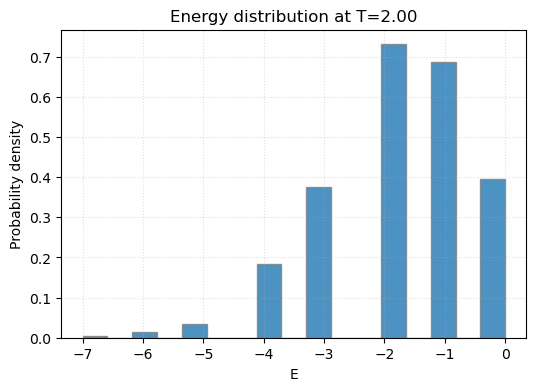

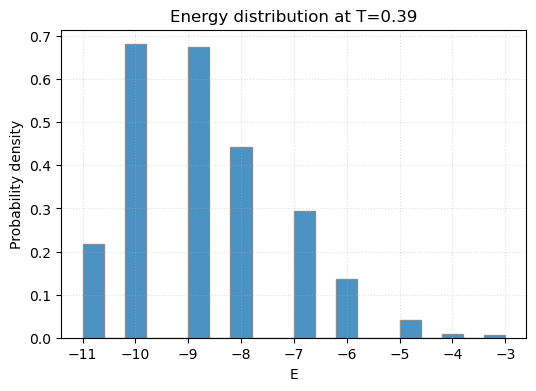

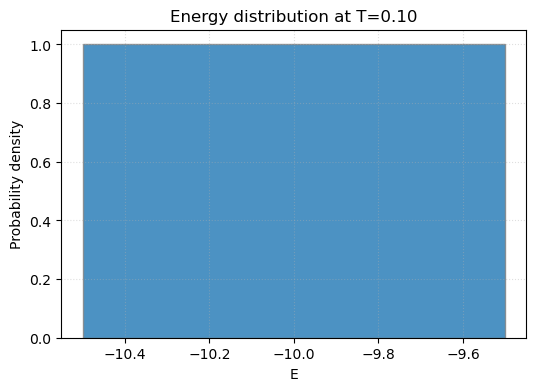

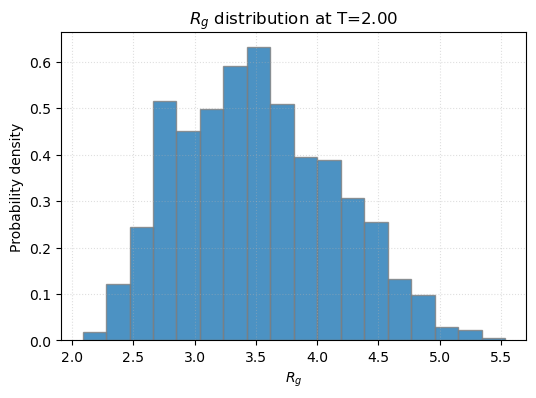

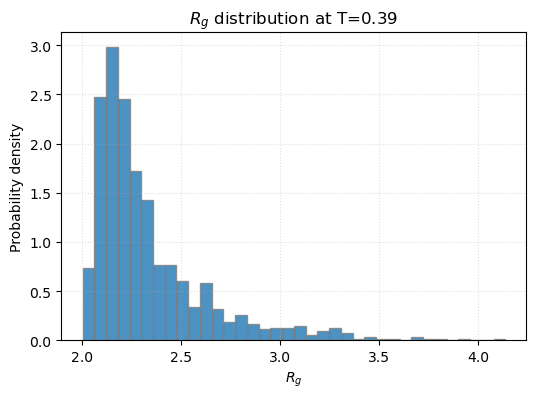

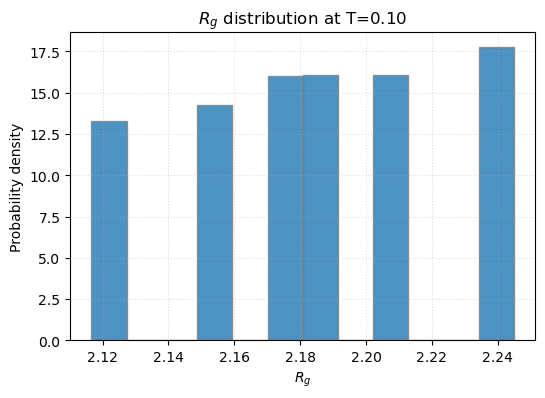

In [24]:
# Energy hists
for T in T_rep:
    E_use = trimmed_by_T_E[T]
    plt.figure(figsize=(6,4))
    plt.hist(E_use, bins='auto', density=True, alpha=0.8, edgecolor='gray')
    plt.title(f"Energy distribution at T={T:.2f}")
    plt.xlabel("E")
    plt.ylabel("Probability density")
    plt.grid(True, linestyle=":", alpha=0.4)
    plt.show()

# Radii of gyration hists
for T in T_rep:
    Rg_use = trimmed_by_T_Rg[T]
    plt.figure(figsize=(6,4))
    plt.hist(Rg_use, bins='auto', density=True, alpha=0.8, edgecolor='gray')
    plt.title(r"$R_g$"+f" distribution at T={T:.2f}")
    plt.xlabel(r"$R_g$")
    plt.ylabel("Probability density")
    plt.grid(True, linestyle=":", alpha=0.4)
    plt.show()

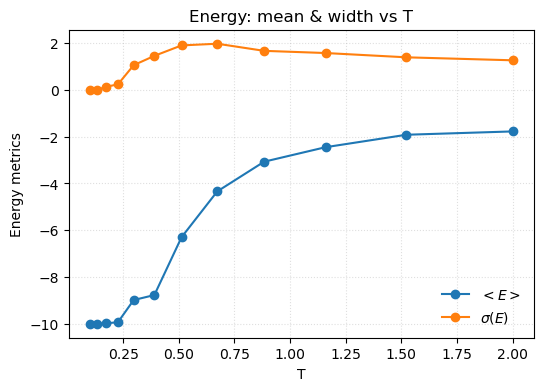

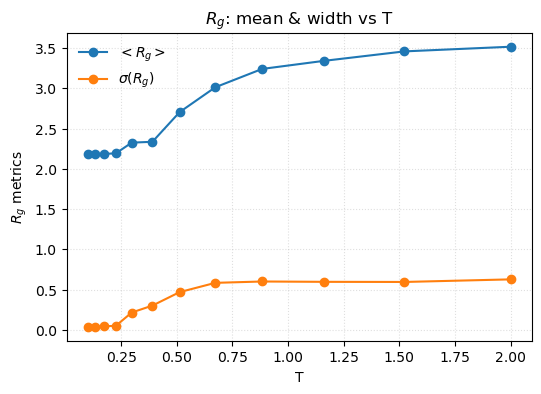

In [25]:
# mean and width vs T
plt.figure(figsize=(6,4))
plt.plot(Ts, means_E, marker='o')
plt.plot(Ts, stds_E, marker='o')
plt.xlabel("T")
plt.ylabel("Energy metrics")
plt.legend([r"$<E>$", r"$\sigma(E)$"], frameon=False)
plt.grid(True, linestyle=":", alpha=0.4)
plt.title("Energy: mean & width vs T")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Ts, means_Rg, marker='o')
plt.plot(Ts, stds_Rg, marker='o')
plt.xlabel("T")
plt.ylabel(r"$R_g$ metrics")
plt.legend([r"$<R_g>$", r"$\sigma(R_g)$"], frameon=False)
plt.grid(True, linestyle=":", alpha=0.4)
plt.title(r"$R_g$: mean & width vs T")
plt.show()

#### Q3:

Heat-capacity peak at T ≈ 0.39 with C ≈ 14


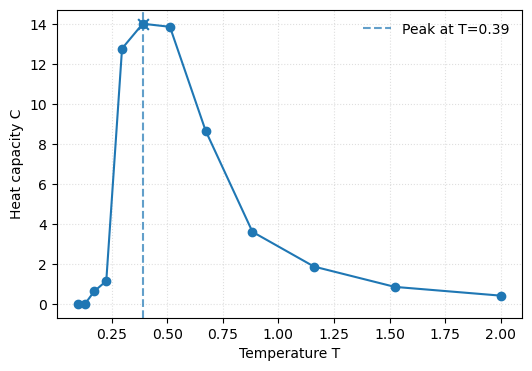

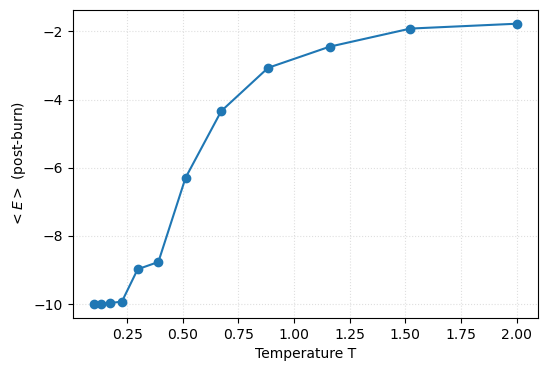

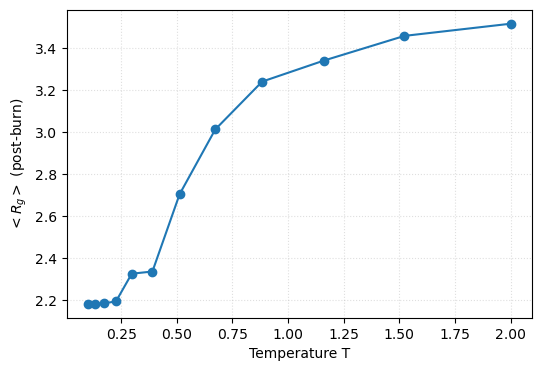

In [26]:
mask = np.isfinite(Cs)
T_peak = Ts[mask][np.argmax(Cs[mask])]
C_peak = Cs[mask].max()
print(f"Heat-capacity peak at T ≈ {T_peak:.3g} with C ≈ {C_peak:.3g}")

plt.figure(figsize=(6,4))
plt.plot(Ts, Cs, marker='o')
plt.axvline(T_peak, ls='--', alpha=0.7, label=f"Peak at T={T_peak:.2f}")
plt.scatter([T_peak], [C_peak], s=60, marker='x')
plt.xlabel("Temperature T")
plt.ylabel("Heat capacity C")
#plt.title("Heat capacity vs Temperature")
plt.legend(frameon=False)
plt.grid(True, linestyle=":", alpha=0.4)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Ts, means_E, marker='o')
plt.xlabel("Temperature T")
plt.ylabel(r"$<E>$ (post-burn)")
#plt.title("Average energy vs Temperature")
plt.grid(True, linestyle=":", alpha=0.4)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Ts, means_Rg, marker='o')
plt.xlabel("Temperature T")
plt.ylabel(r"$<R_g>$ (post-burn)")
#plt.title("Radius of gyration vs Temperature")
plt.grid(True, linestyle=":", alpha=0.4)
plt.show()


### The Role of Hydrophobicituy

#### Q1:

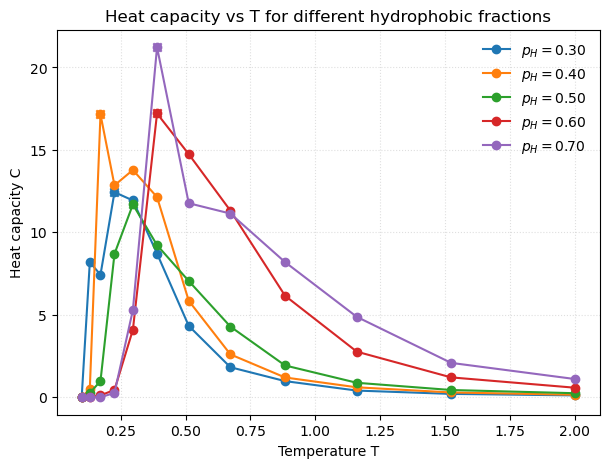

Peak temperature per hydrophobic fraction:
p_H=0.30: T_peak=0.226, C_peak=12.435
p_H=0.40: T_peak=0.172, C_peak=17.155
p_H=0.50: T_peak=0.297, C_peak=11.69
p_H=0.60: T_peak=0.39, C_peak=17.208
p_H=0.70: T_peak=0.39, C_peak=21.227


In [27]:
p_list = [0.3, 0.4, 0.5, 0.6, 0.7]
N = N_bm
random.seed(111)

E_min_global = {}
coords_min = {}
coords_final = {}
seqs_per_p = {}
C_curves = {}
T_peaks = {}

for p in p_list:
    # new protein at this hydrophobic fraction
    coords, seq = random_walk_hp(N, p_H=p, seed=10000+int(100*p))
    E, _ = energy_hp(coords, seq)

    seqs_per_p[p] = seq
    E_best = E
    coords_best = coords[:]
    
    Cs = []
    for T in T_schedule:
        E_samp = []
        accepted = 0

        for s in range(1, steps_per_T + 1):
            # propose a move (retry a few times if proposal doesn't change geometry)
            trial = coords
            for _ in range(attempt_cap):
                if random.random() < 0.5:
                    cand, *_ = kink_or_end_move(coords)
                else:
                    cand, *_ = pivot_move(coords)
                if cand != coords:
                    trial = cand
                    break

            if trial != coords:
                E_trial, _ = energy_hp(trial, seq)
                dE = E_trial - E
                if dE <= 0 or (T > 0 and random.random() < np.exp(-dE/T)):
                    coords = trial
                    E = E_trial
                    accepted += 1
                    
                    if E < E_best:
                        E_best = E
                        coords_best = coords[:]

            if s % sample_every == 0:
                E_samp.append(E)

        # heat capacity with 10% burn-in removed (k_B = 1 in reduced units)
        if E_samp:
            b = max(1, len(E_samp)//10)
            Es = np.array(E_samp[b:], dtype=float)
            C = (np.mean(Es**2) - np.mean(Es)**2)/(T**2) if len(Es) > 1 else float('nan')
        else:
            C = float('nan')
        Cs.append(C)

    C_curves[p] = Cs
    arr = np.array(Cs, dtype=float)
    idx = np.nanargmax(arr)
    T_peaks[p] = (T_schedule[idx], arr[idx]) if idx is not None else (None, None)
    
    E_min_global[p] = E_best
    coords_min[p] = coords_best
    coords_final[p] = coords[:]

# plot C(T) for each p_H
plt.figure(figsize=(7,5))
for p in p_list:
    plt.plot(T_schedule, C_curves[p], marker='o', label=r"$p_H=$"+f"{p:.2f}")
    Tp, Cp = T_peaks[p]
    if Tp is not None:
        plt.scatter([Tp], [Cp], marker='x')
plt.xlabel("Temperature T")
plt.ylabel("Heat capacity C")
plt.title("Heat capacity vs T for different hydrophobic fractions")
plt.grid(True, linestyle=":", alpha=0.4)
plt.legend(frameon=False)
plt.show()

# peak report
print("Peak temperature per hydrophobic fraction:")
for p in p_list:
    Tp, Cp = T_peaks[p]
    print(f"p_H={p:.2f}: T_peak={None if Tp is None else round(Tp, 3)}, C_peak={None if Cp is None else round(Cp, 3)}")


#### Q2:

In [28]:
print("\nGlobal minimum energy reached during the annealing run:")
for p in p_list:
    print(f"p_H={p:.2f}: E_min = {E_min_global[p]:.1f}")

print("\nEnergy of final conformation at lowest T in schedule:")
for p in p_list:
    E_final, _ = energy_hp(coords_final[p], seqs_per_p[p])
    print(f"p_H={p:.2f}: E_final = {E_final:.1f}")


Global minimum energy reached during the annealing run:
p_H=0.30: E_min = -5.0
p_H=0.40: E_min = -6.0
p_H=0.50: E_min = -7.0
p_H=0.60: E_min = -12.0
p_H=0.70: E_min = -15.0

Energy of final conformation at lowest T in schedule:
p_H=0.30: E_final = -5.0
p_H=0.40: E_final = -6.0
p_H=0.50: E_final = -7.0
p_H=0.60: E_final = -12.0
p_H=0.70: E_final = -14.0



Conformation at global minimum energy for p_H=0.30, E_min=-5.0


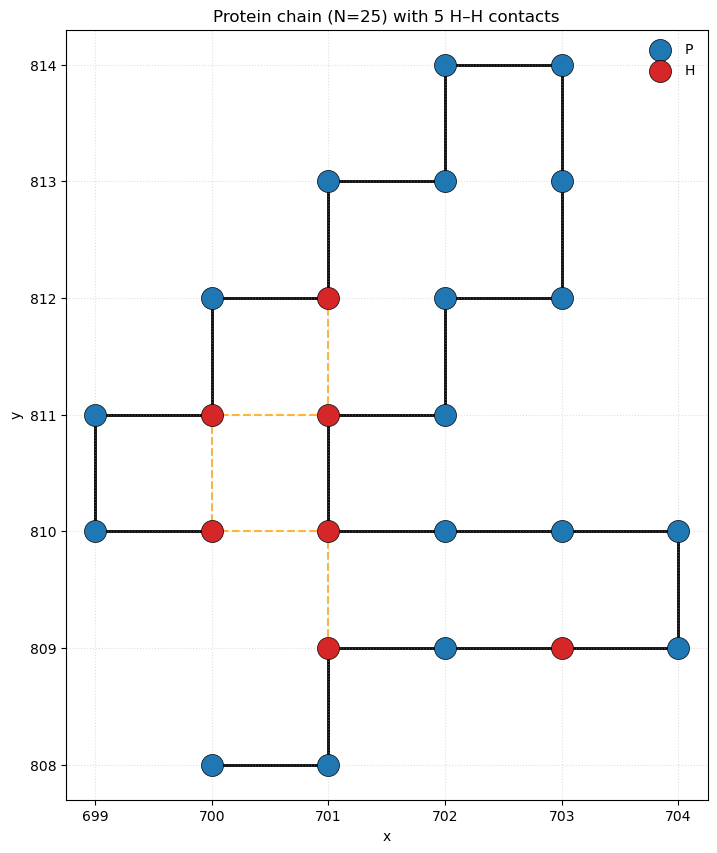


Conformation at global minimum energy for p_H=0.40, E_min=-6.0


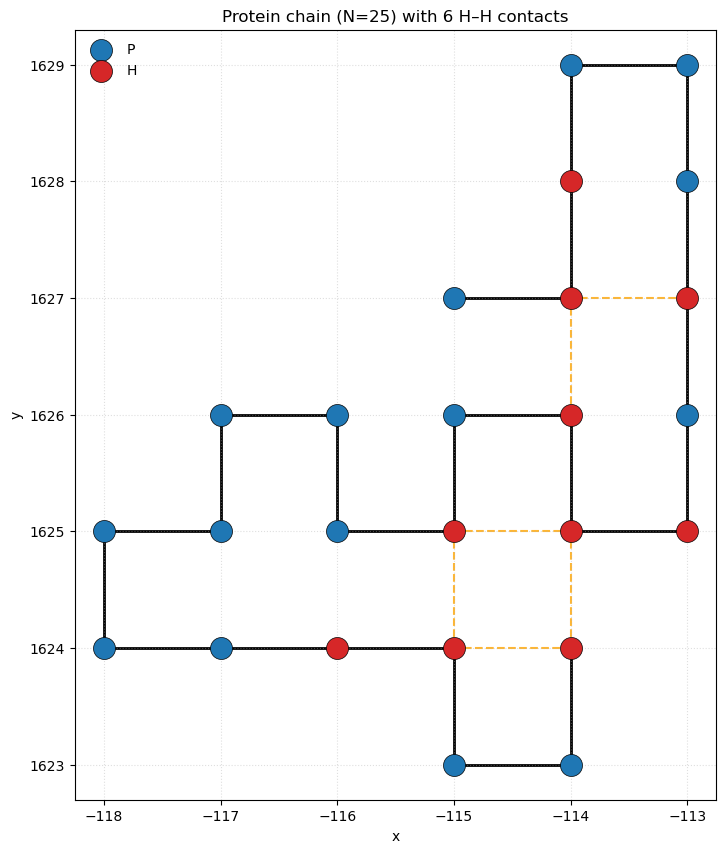


Conformation at global minimum energy for p_H=0.50, E_min=-7.0


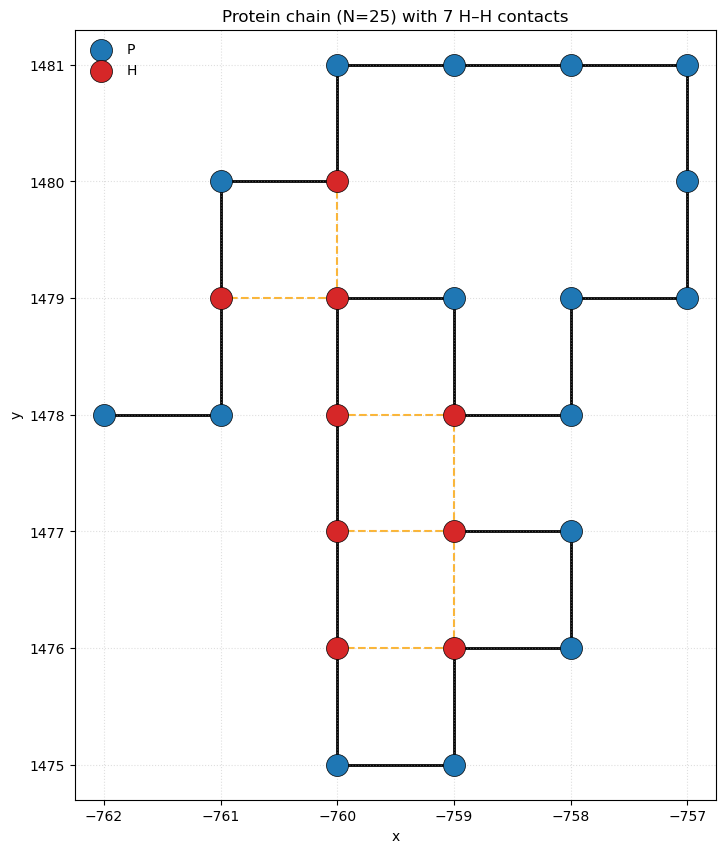


Conformation at global minimum energy for p_H=0.60, E_min=-12.0


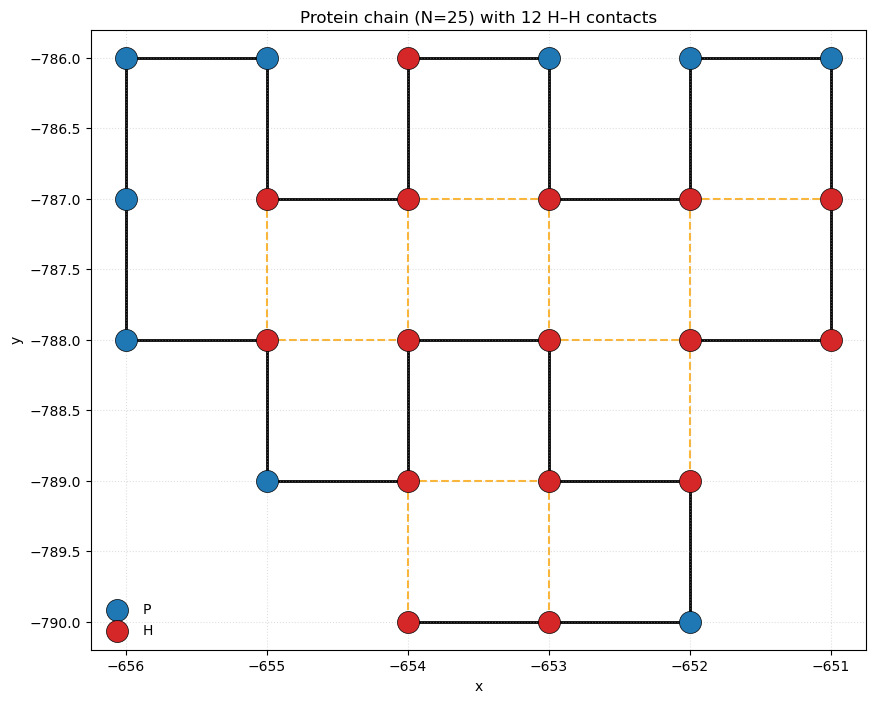


Conformation at global minimum energy for p_H=0.70, E_min=-15.0


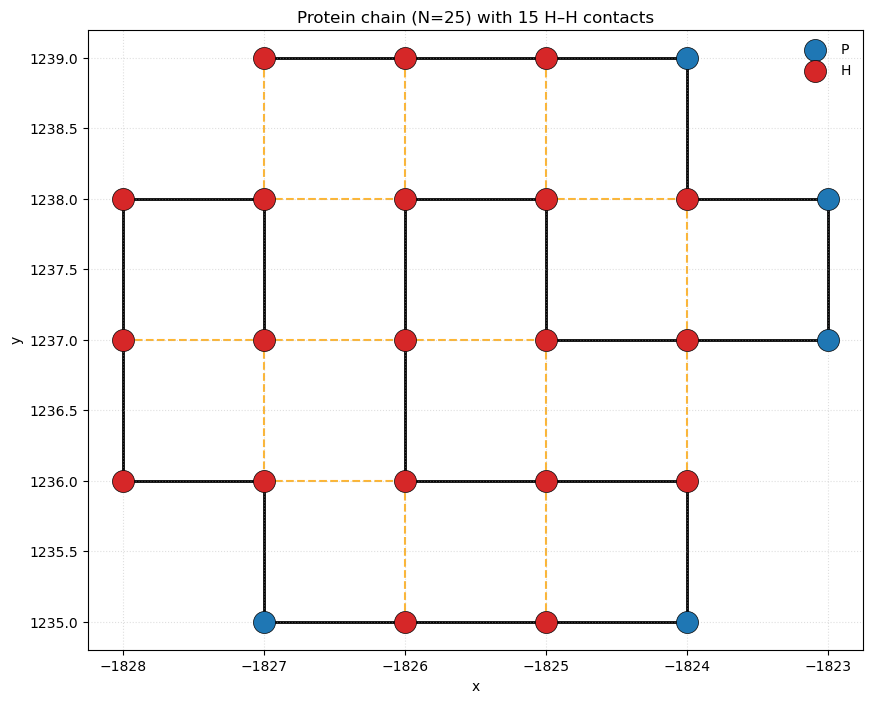


Final conformation at lowest T for p_H=0.30


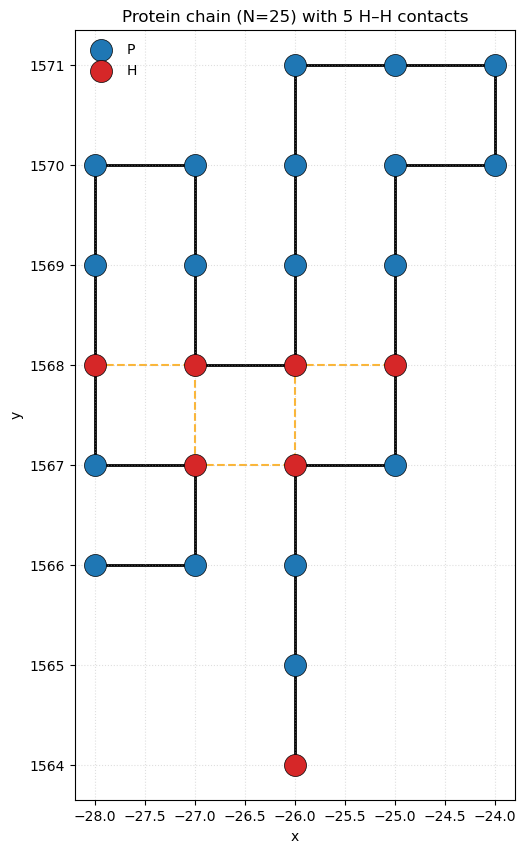


Final conformation at lowest T for p_H=0.40


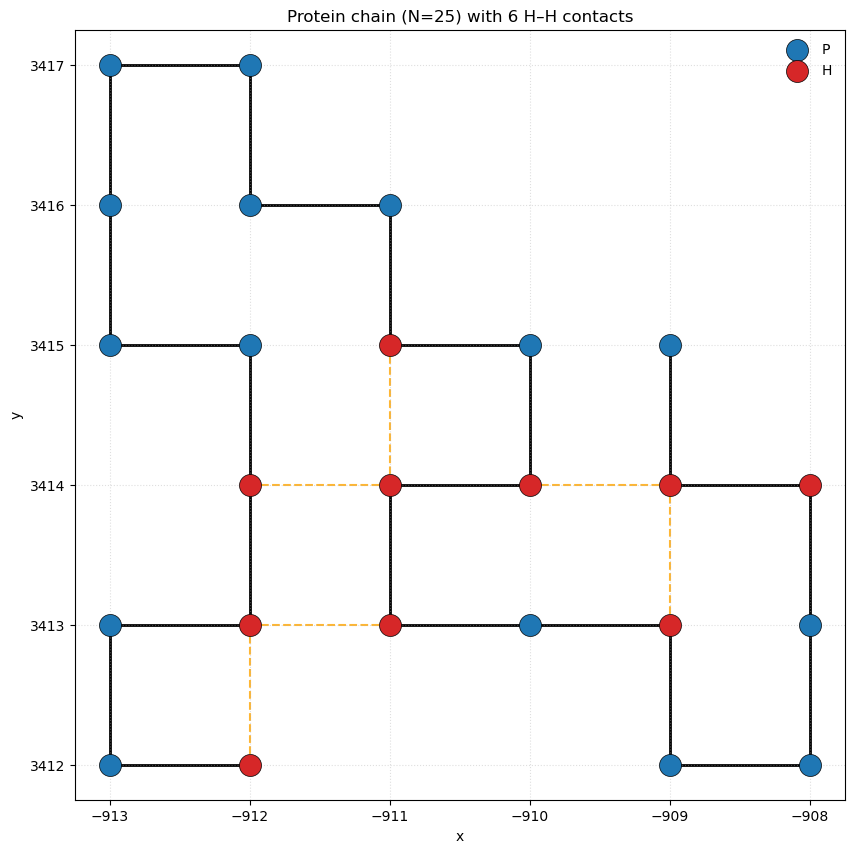


Final conformation at lowest T for p_H=0.50


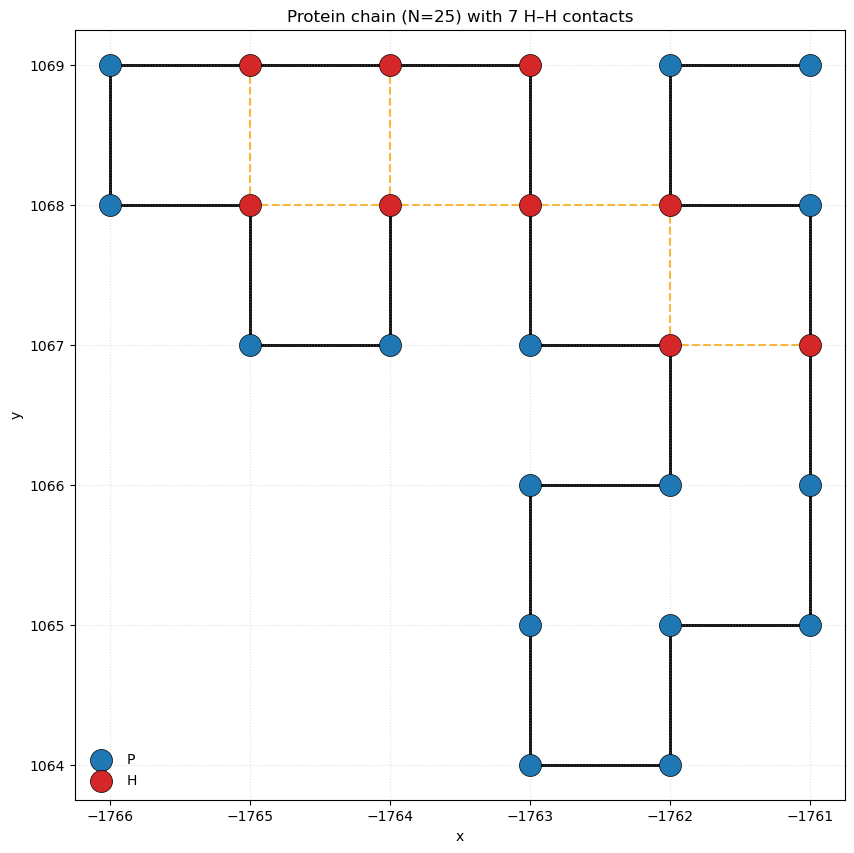


Final conformation at lowest T for p_H=0.60


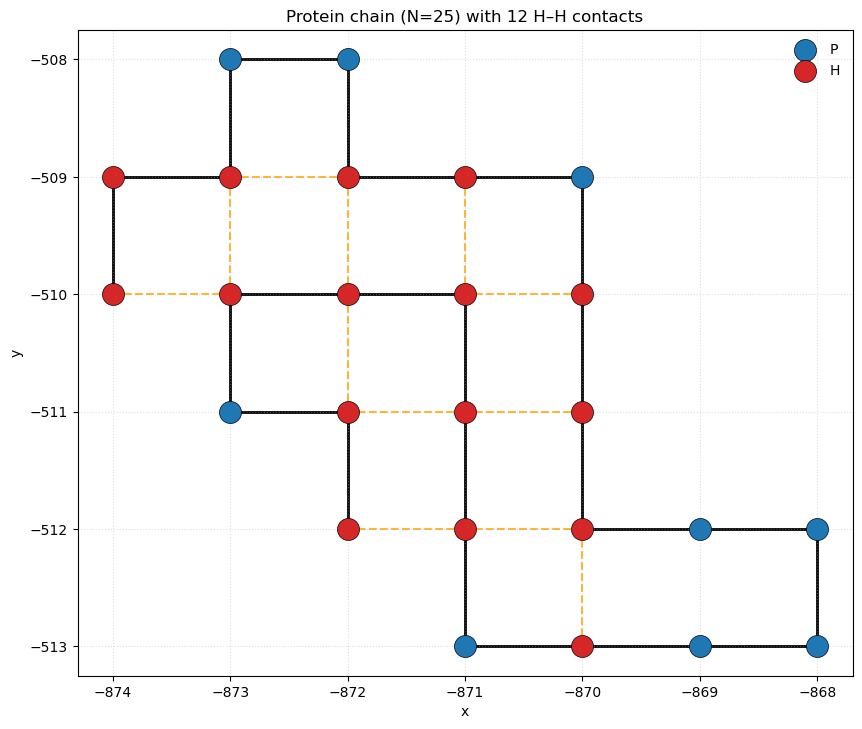


Final conformation at lowest T for p_H=0.70


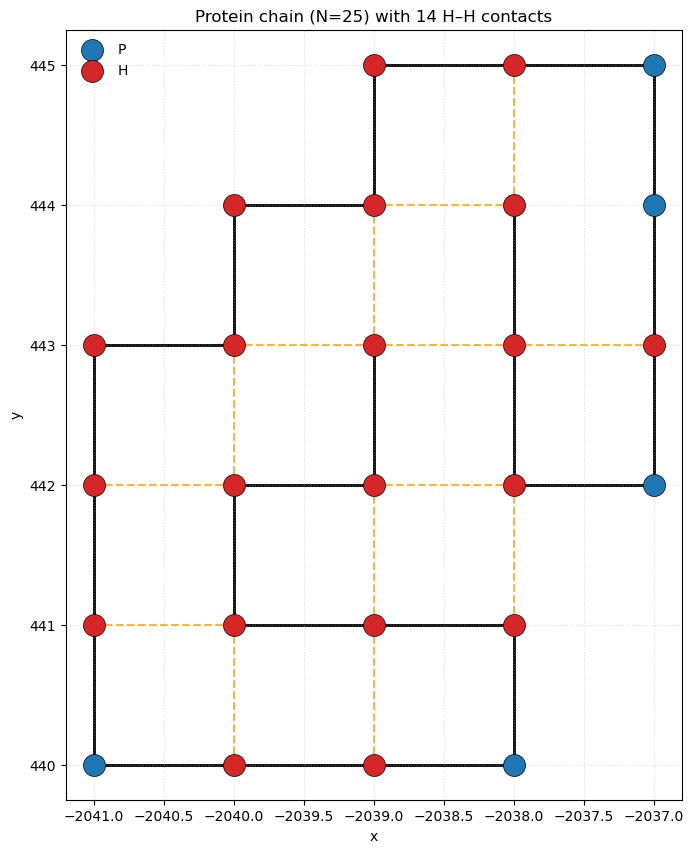

In [29]:
for p in p_list:
    fname = f"FA_outputs/min_conf_pH_{int(100*p):02d}.png"
    print(f"\nConformation at global minimum energy for p_H={p:.2f}, E_min={E_min_global[p]:.1f}")
    visualize_chain(coords_min[p], seqs_per_p[p], show_index=False, savepath=fname)

for p in p_list:
    fname = f"FA_outputs/final_conf_pH_{int(100*p):02d}.png"
    print(f"\nFinal conformation at lowest T for p_H={p:.2f}")
    visualize_chain(coords_final[p], seqs_per_p[p], show_index=False, savepath=fname)